# Group 44 Final Project CS109B - Twitter
## Tweet Database Generator



**Spring 2019**<br/>
**Authors**: Daniel Barjum, Yalda Amini, João Araújo

<hr style="height:2pt">

## 0. Introduction

We set out to create a machine learning model that predicts whether a user is a bot or not based on Twitter data for that user.

Our main approach wast to generate a neural network that analyzes many features for multiple tweets coming from multiple users. Below is the detailed approach along with the code used to test whether a user was a bot or not.


### Description of Data

We obtained data from from MIB researcher's database. We were granted access to the data for use on this project. Information on the dataset can be obtained here: http://mib.projects.iit.cnr.it/dataset.html

The original database contained multiple levels of information for each tweet coming from many users. Some data were useful, some were not. We analyzed this data and removes variables that we deemed were not necesarry for predicting whether an acocunt is a bot. A description of the data obtained is described in the image below which was obtained from the MIB website. 

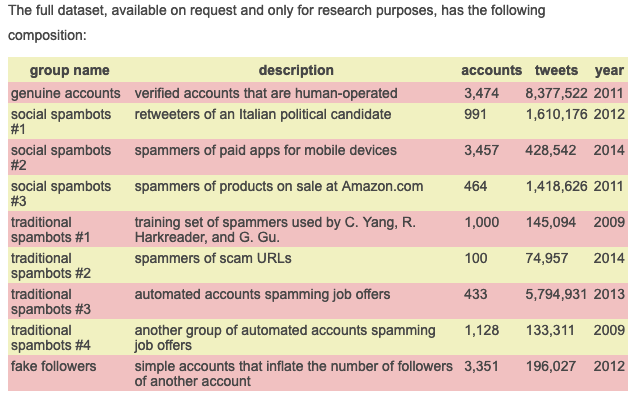

Unfortunatley, when we downloaded the data, the numbers did not match up exactly with the numbers above. The dataset we downloaded contained a bit over 6.6 million tweets coming from a bit over 9,700 users. This is still more than enough data for use to develop a model for predicting bot or not.

## 1. Body

### Generated Clean Tweet Database

The datasets we obtained were not clean, it contained raw information. This task was very ardous as we are working with over 6 million observations and over 30 features. Additionally, some data needed to be turned into neural-network readable data in order for us to use it as such.

The general purpose of this section of code is to clean the 'twitter.csv' files we obtained from the researchers' dataset. These sets contained lots of information and some missing data. We handle the missing data accordingly and clean the dataset for use in the neural network. Explanations of what we did and how we proceeded is presented throughouth the code

The orignal dataset contained a bit over 6.6 million tweets coming from a bit over 9,700 users. 

As we proceed to clean the data, we learn new things that eventually led to the creation of features from the data to be used in the NN.

In [1]:
#imports for cleaning tweet database
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

from sklearn.preprocessing import OneHotEncoder

In [2]:
#Define paths to files where data is stored

path = os.getcwd()+'/data/datasets_full/'

#the datasets were separated into multiple folders with csv files
folders = ['genuine_accounts/', 'social_spambots_1/', 'social_spambots_2/', 
           'social_spambots_3/', 'traditional_spambots_1/', 'traditional_spambots_2/',
           'traditional_spambots_3/', 'traditional_spambots_4/', 'fake_followers/']

file_names = ['users.csv', 'tweets.csv']

The data contains differing variable types for some columns which difficults and slows the process of reading into a pandas dataframe. Here we define how some columns should be read into pandas in order to avoid warning and speed up the process a bit. 

Some columns, although numerical in nature, were coerced into strings as they are more useful in that manner. For example, columns that have a user id were changed into a string instead of an int or float as we can use this number if we need to request information from Twitter's API which would prefer to see strings.

In [3]:
#define datatype for some columns to speed up process and avoid warnings when reading raw data
type_dic = {'user_id': str, 'id': str, 'contributors': str,
            'crawled_at': str, 'in_reply_to_screen_name': str,
            'place': str, 'retweeted_status_id': str, 
            'in_reply_to_screen_name': str, 'in_reply_to_status_id': str,
            'in_reply_to_user_id': str, 'updated': str, 'created_at': str}

Read in databases and append each one into a single database. Show number of datapoints being read from each database and final count of observations.

The try-except is there to catch any errors from reading the files or if files do not exits. We discovered that some files were missing from the researchers data, so we just ignore these files during the reading

In [4]:
df = pd.DataFrame()

for f in folders:
    try:
        temp_df = pd.read_csv(path+f+file_names[1], dtype=type_dic)
        if f == 'genuine_accounts/':
            real_count = len(temp_df)
        print('File {0} has shape of: {1}'.format(f+file_names[1], temp_df.shape))
        df = df.append(temp_df, ignore_index=True, sort=True)
    except FileNotFoundError:
        print('File {:s} not found, ignoring'.format(f+file_names[1])) 

print('final tweet database is of shape {0}'.format(df.shape))

File genuine_accounts/tweets.csv has shape of: (2839362, 25)
File social_spambots_1/tweets.csv has shape of: (1610034, 25)
File social_spambots_2/tweets.csv has shape of: (428542, 25)
File social_spambots_3/tweets.csv has shape of: (1418557, 25)
File traditional_spambots_1/tweets.csv has shape of: (145094, 25)
File traditional_spambots_2/tweets.csv not found, ignoring
File traditional_spambots_3/tweets.csv not found, ignoring
File traditional_spambots_4/tweets.csv not found, ignoring
File fake_followers/tweets.csv has shape of: (196027, 23)
final tweet database is of shape (6637616, 25)


We will add labels for bots = 1 and real accounts = 0 at this stage as we know if they are or are not bots right after reading.

In [5]:
bots = np.ones(len(df))
np.put(bots, list(range(real_count)), 0)
df['bots'] = bots

### Data Cleaning and Feature Engineering
<hr style="height:1pt">

We now turn to data cleaning and feature engineering for use in neural network for detecting bots. As we searched the literature on how to approach this problem, we learned that feature engineering was key to developing a good set of predictors that helps improve the accuracy of the model. We took advice from the work done with Botometer, a network used for detection of bots created by Indiana University (https://botometer.iuni.iu.edu/#!/). As seen in the image below, they created over 1000 features for use in their network. We were not so ambitious, but we gathered that feature engineering was important for this work to succeed.

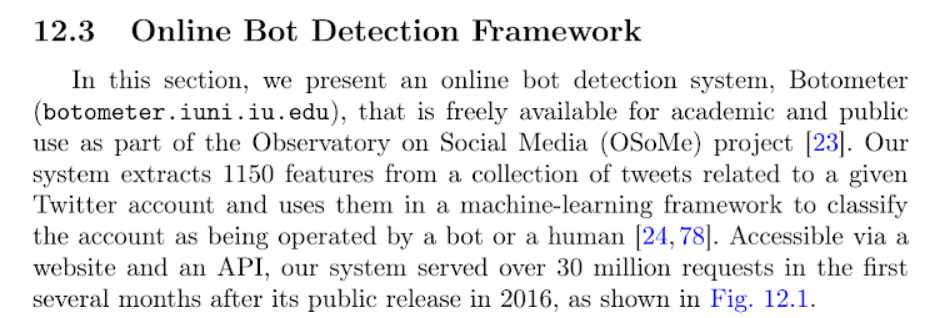

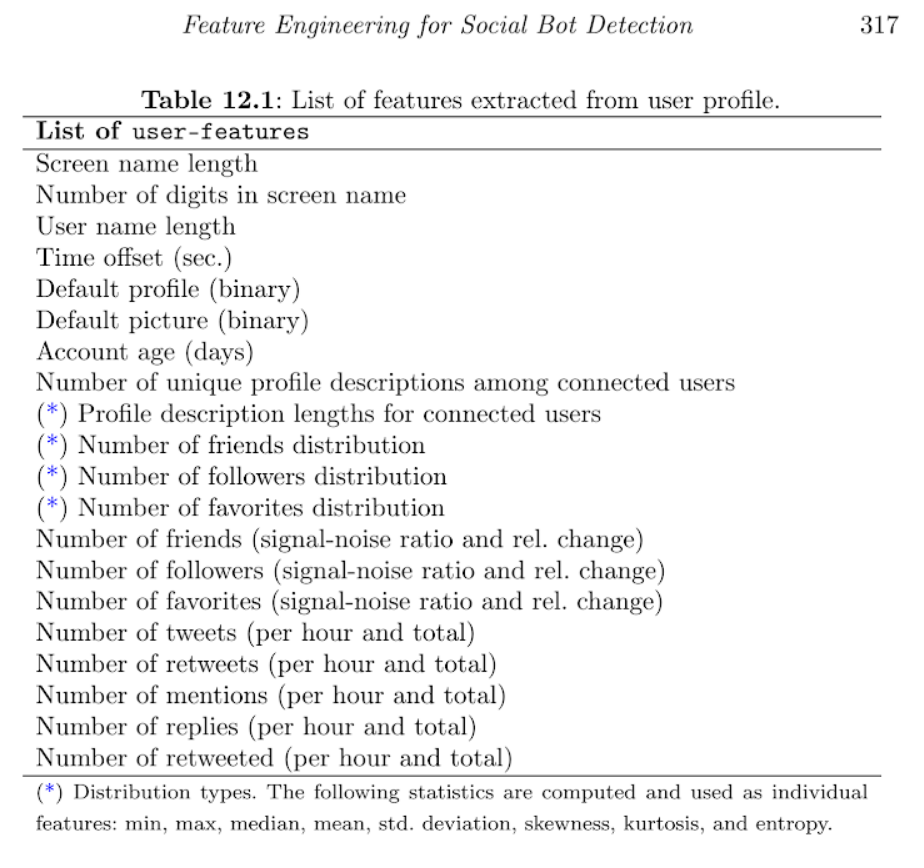

We proceeded to continue to clean data and generate features as we progressed through the data.

We noticed that some columns contain no information at all. This next section of code checks for columns that contain no information and drops these columns from the dataframe.

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

empty_cols = []
for c in df.select_dtypes(include=numerics).columns:
    if len(np.isnan(df[c].unique()))==1 & np.isnan(df[c].unique())[0]:
        empty_cols.append(c)

df = df.drop(empty_cols, axis=1)
print('The following columns only contained nulls: {0}, these have been dropped'.format(empty_cols))

The following columns only contained nulls: ['favorited', 'geo', 'retweeted'], these have been dropped


In [7]:
df.shape

(6637616, 23)

In [8]:
df.describe()

,favorite_count,num_hashtags,num_mentions,num_urls,possibly_sensitive,reply_count,retweet_count,truncated,bots
count,6.637615e+06,6.637615e+06,6.637615e+06,6.637615e+06,26812.0,6.637615e+06,6.637615e+06,753.0,6.637616e+06
mean,2.352860e+00,1.561749e-01,3.908975e-01,2.003855e-01,1.0,2.848357e-02,3.832842e+02,1.0,5.722317e-01
std,3.313966e+02,5.913658e-01,7.311432e-01,4.062391e-01,0.0,1.474201e+01,1.100351e+04,0.0,4.947551e-01
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,1.0,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,1.0,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,1.0,1.000000e+00
75%,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,1.0,1.000000e+00
max,1.353000e+05,2.800000e+01,1.900000e+01,6.000000e+00,1.0,2.751600e+04,3.350111e+06,1.0,1.000000e+00


we notice from the describe above that some columns have very few observations (possibly_sensitive and truncated). Reading Twitter's API pages about these two variables, we deemed that it was safe to drop this variable for analysis as 1) it has few observations, and 2) the values are not very useful as they proxy other variables.

See https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html for information about variables

In [9]:
df = df.drop(['possibly_sensitive','truncated'], axis=1)

In [10]:
df.head()

,contributors,crawled_at,created_at,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,num_hashtags,num_mentions,...,place,reply_count,retweet_count,retweeted_status_id,source,text,timestamp,updated,user_id,bots
0,NaN,2015-05-01 12:57:19,Fri May 01 00:18:11 +0000 2015,0.0,593932392663912449,NaN,0,0,0.0,1.0,...,NaN,0.0,1.0,593932168524533760,"<a href=""http://tapbots.com/tweetbot"" rel=""nof...",RT @morningJewshow: Speaking about Jews and co...,2015-05-01 02:18:11,2015-05-01 12:57:19,678033,0.0
1,NaN,2015-05-01 12:57:19,Thu Apr 30 21:50:52 +0000 2015,0.0,593895316719423488,NaN,0,0,0.0,0.0,...,NaN,0.0,0.0,0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This age/face recognition thing..no reason pla...,2015-04-30 23:50:52,2015-05-01 12:57:19,678033,0.0
2,NaN,2015-05-01 12:57:19,Thu Apr 30 20:52:32 +0000 2015,0.0,593880638069018624,NaN,0,0,2.0,0.0,...,NaN,0.0,0.0,0,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Only upside of the moment I can think of is th...,2015-04-30 22:52:32,2015-05-01 12:57:19,678033,0.0
3,NaN,2015-05-01 12:57:19,Thu Apr 30 18:42:40 +0000 2015,1.0,593847955536252928,NaN,0,0,2.0,0.0,...,NaN,0.0,2.0,0,"<a href=""http://tapbots.com/tweetbot"" rel=""nof...",If you're going to think about+create experien...,2015-04-30 20:42:40,2015-05-01 12:57:19,678033,0.0
4,NaN,2015-05-01 12:57:19,Thu Apr 30 18:41:36 +0000 2015,0.0,593847687847350272,NaN,0,0,0.0,0.0,...,NaN,0.0,0.0,0,"<a href=""http://tapbots.com/tweetbot"" rel=""nof...",Watching a thread on FB about possible future ...,2015-04-30 20:41:36,2015-05-01 12:57:19,678033,0.0


We also notice that columns 'contributors', 'in_reply_to_screen_name', and 'place' appear to have lots of NaNs, let's look at the columns to see if they contain useful information

In [11]:
for c in ['contributors', 'in_reply_to_screen_name', 'place']:
    print('column {:s} has {:d} unique values:'.format(c, len(df[c].unique())))
    print(df[c].unique())
    print()

column contributors has 1 unique values:
[nan]

column in_reply_to_screen_name has 271336 unique values:
[nan 'thelancearthur' 'wkamaubell' ... 'QueenBitchEnt' 'QBLilKim'
 'TokyozFinest1']

column place has 3191 unique values:
[nan 'Tucson, AZ' 'Casas Adobes, AZ' ... 'Cártama, Malaga'
 'Chalco, Messico' 'Universiti Multimedia, Bukit Baru']



ok, seems like 'contributors' column is empty so we will remove this column. The other two columns do seem to contain information about tweets and we will keep them for now.

In [12]:
df = df.drop('contributors', axis=1)

Let's check if some columns that should contain a numerical value contain any Null values.

In [13]:
for c in df.columns:
    if df[c].isna().sum() > 0:
        print('column {:s} has {:d} null values'.format(c, df[c].isna().sum()))

column crawled_at has 196028 null values
column created_at has 1 null values
column favorite_count has 1 null values
column in_reply_to_screen_name has 5598482 null values
column in_reply_to_status_id has 1 null values
column in_reply_to_user_id has 1 null values
column num_hashtags has 1 null values
column num_mentions has 1 null values
column num_urls has 1 null values
column place has 6508965 null values
column reply_count has 1 null values
column retweet_count has 1 null values
column retweeted_status_id has 196028 null values
column source has 73 null values
column text has 13007 null values
column timestamp has 1 null values
column updated has 196028 null values
column user_id has 1 null values


We notice a few things here. There are several columns with only 1 null value, and some columns with many null values. Let's explore further to determine if we can fill this missing data or if we can drop them.

We will first check all columns that contain only 1 null, maybe they all point the the exact same observation. if this is the case, then we could simply delete this observation and we would only loose a single data point.

In [14]:
single_nulls = ['created_at', 'favorite_count', 'in_reply_to_status_id',
                'in_reply_to_user_id', 'num_hashtags', 'num_mentions', 
                'num_urls', 'reply_count', 'retweet_count', 'timestamp', 'user_id']

for c in single_nulls:
    print('index {:d} is where the null is for column {:s}'.format(df.loc[df[c].isna()].index[0],c))

index 2839361 is where the null is for column created_at
index 2839361 is where the null is for column favorite_count
index 2839361 is where the null is for column in_reply_to_status_id
index 2839361 is where the null is for column in_reply_to_user_id
index 2839361 is where the null is for column num_hashtags
index 2839361 is where the null is for column num_mentions
index 2839361 is where the null is for column num_urls
index 2839361 is where the null is for column reply_count
index 2839361 is where the null is for column retweet_count
index 2839361 is where the null is for column timestamp
index 2839361 is where the null is for column user_id


as expected, they all correspond to same observation, so lets delete this observation

In [15]:
df = df.drop(df.loc[df.created_at.isna()].index[0], axis=0)

columns 'crawled_at'and 'updated' were columns added by the researchers. They used twitter crawlers to collect information for this database. These columns do not belong to information about users that can be collected through Twitter's API, hence we will drop these two columns.

In [16]:
df = df.drop(['crawled_at', 'updated'], axis=1)

In [17]:
for c in df.columns:
    if df[c].isna().sum() > 0:
        print('column {:s} has {:d} null values'.format(c, df[c].isna().sum()))

column in_reply_to_screen_name has 5598481 null values
column place has 6508964 null values
column retweeted_status_id has 196027 null values
column source has 72 null values
column text has 13006 null values


the varaibles in_reply_to_screen_name and place have large amounts of null values. When looking at Twitter's API description of these variables, we find that these values are null if:
- for in_reply_to_screen_name if the tweet is not a reply
- for place, if the tweet has no location data

This presents an interesting opportunity. Let's see what percentage of tweets that have either place data or in_reply_to_screen_name data correspond to genuine accounts

In [18]:
df.loc[df.in_reply_to_screen_name.isna()==False].bots.sum()/len(df.loc[df.in_reply_to_screen_name.isna()==False])

0.20234637688690776

In [19]:
df.loc[df.place.isna()==False].bots.sum()/len(df.loc[df.place.isna()==False])

0.05719349247188129

These are interesting results. Of the tweets that are replies, only 20% come from bots. And of the tweets that have location data, only 5% come from bots.

Since the actual value of in_reply_to_screen_name and place variable is not very important as they have small sample sizes, we will create a binary variable for each to indicate if a tweet is a reply, and if a tweet has place data. This might prove to be more useful than the actual value it currently holds. We will drop the original columns

In [20]:
reply = np.zeros(len(df))
idx = df.loc[df.in_reply_to_screen_name.isna()==False].index
np.put(reply, idx, 1)

location_data = np.zeros(len(df))
idx = df.loc[df.place.isna()==False].index
np.put(location_data, idx, 1)

df['reply'] = reply
df['location_data'] = location_data

df = df.drop(['place','in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_user_id', 'id'], axis=1)

text feature, which corresponds to the text of the tweet also presents some missing data. We will leave this untouched for now. But let's create a feature that counts the number of words in a tweet. Those tweets without text will be assumed to have 0 number of words.

In [21]:
num_words = []
for i, s in enumerate(df.text):
    try:
        num_words.append(len(s.split()))
    except AttributeError:
        num_words.append(0)

df['num_words'] = num_words

We searched information on retweeted_status_id represents and we did not find any good information on it. There is a variable on twitter called retweeted_status, but it differs in data format from the one we have. Our guess is that the variable we have represents the id of the user for which the twitter is being retweeted. Since we won't be acquiring additional data outside the dataset we received from the researchers, we will be dropping this column. 

In [22]:
df = df.drop('retweeted_status_id', axis=1)

In [23]:
for c in df.columns:
    if df[c].isna().sum() > 0:
        print('column {:s} has {:d} null values'.format(c, df[c].isna().sum()))

column source has 72 null values
column text has 13006 null values


the source column represents information related to source about the infrastructure where the tweet came from. For example, if it was typed through twitter online, it will say so, if it was typed through twitter on a phone, it will say something like "twitter for android" or "twitter for ios", etc.

This might prove to be an important feature. We will fill the 72 missing values with the most common value as it is only 72 observations (tiny when compared to the number of total observations). Then, we will categorize the sources from most common to least common into 10 categories which will then be one-hot-encoded.

In [24]:
source = df.source.str.extract(r'>\s*([^\.]*)\s*\<', expand=False)

In [25]:
source_counts = source.value_counts()

In [26]:
df = df.fillna({'source':source_counts.index[0]}, axis=0)

Let's take a look at the distribution of source to see how we can categorize them

In [27]:
source_norm = (source_counts-source_counts.min())/(source_counts.max()-source_counts.min())

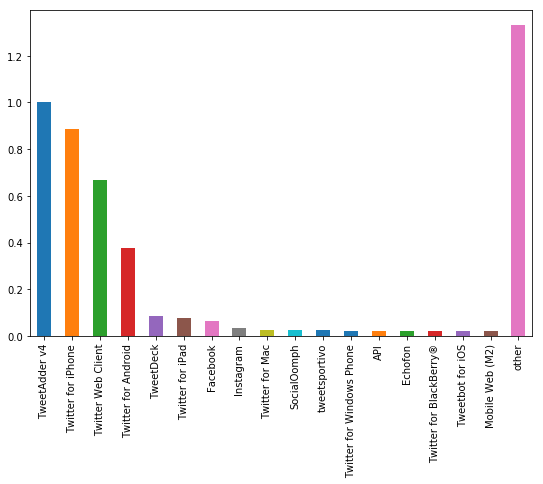

In [28]:
fig, ax = plt.subplots(figsize=(9,6))

threshold = 0.02
mask = source_norm > threshold
tail_prob = source_norm.loc[~mask].sum()
prob = source_norm.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.show()

we can see from the above distribution that the most common values are TweetAdder v4, Twitter for iPhone, Twitter Web Client, and Twitter for Android. we will split the data into 10 bins corresponding to the top 9 sources and then a category for all the rest.

In [29]:
l = list(source_counts.index[0:9])
source_new = []
for s in source:
    if s in l:
        source_new.append(s)
    else:
        source_new.append('other')      

In [30]:
df['source'] = source_new

In [31]:
df = pd.get_dummies(df, columns=['source'])

It is important to manage the timestamp of tweets and engineer some features from this variable. We will focus on extracting the year, month, day, hour, minutes and second in which a tweet was made and also for each unique user, how often they tweet.

In [32]:
%%time
df.created_at = pd.to_datetime(df.created_at, errors='coerce')

CPU times: user 22min 40s, sys: 1min 5s, total: 23min 45s
Wall time: 23min 45s


In [33]:
pd.isnull(df.created_at).sum()

145094

we have about 145,000 observations that don't contain data of when the tweet was created. We will delete these observations as we still have a lot of millions of observations.

In [34]:
df = df.drop(df.loc[pd.isnull(df.created_at)==True].index, axis=0)

In [35]:
df['year'] = df.created_at.dt.year
df['month'] = df.created_at.dt.month
df['day'] = df.created_at.dt.day
df['hour'] = df.created_at.dt.hour
df['minute'] = df.created_at.dt.minute
df['second'] = df.created_at.dt.second

In [36]:
list(df.columns)

['created_at',
 'favorite_count',
 'num_hashtags',
 'num_mentions',
 'num_urls',
 'reply_count',
 'retweet_count',
 'text',
 'timestamp',
 'user_id',
 'bots',
 'reply',
 'location_data',
 'num_words',
 'source_Facebook',
 'source_Instagram',
 'source_TweetAdder v4',
 'source_TweetDeck',
 'source_Twitter Web Client',
 'source_Twitter for Android',
 'source_Twitter for Mac',
 'source_Twitter for iPad',
 'source_Twitter for iPhone',
 'source_other',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second']

We store the clean data into a csv for future use.

In [37]:
df.to_csv('data/clean_tweets.csv')

### Cleaning User Data and Model

Import functions that will be necessary throughout the algorithm.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Activation, Input, Reshape, InputLayer, Lambda, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy

# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


Read the data for users in the first file, to create the dataframe

In [2]:
df_users = pd.read_csv("data/datasets_full/genuine_accounts/users.csv")
df_users["bots"] = 0
df_users.head()
df_users.shape

(3474, 43)

Create list of all the other files from which I want to read user's data. Then append data from each of these files into the dataframe created above. 

In [3]:
user_files = ["fake_followers", "social_spambots_1", "social_spambots_2", "social_spambots_3", 
              "traditional_spambots_1", "traditional_spambots_2", "traditional_spambots_3", "traditional_spambots_4"]

In [4]:
for i in user_files:
    df_temp = pd.read_csv("data/datasets_full/" + i + "/users.csv")
    df_temp["bots"] = 1
#     print (i, df_temp.shape)
    df_users = df_users.append(df_temp, ignore_index=True)
#     print (df_users.shape)
# print (df_users.shape)

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Exclude columns "test_set_1", "test_set_2", which are not useful to our work, and is not consistently present in all files

In [5]:
df_users = df_users.drop(["test_set_1", "test_set_2"], axis = 1)
df_users.shape

(14368, 41)

In [6]:
df_users.head()

,bots,contributors_enabled,crawled_at,created_at,default_profile,default_profile_image,description,favourites_count,follow_request_sent,followers_count,...,profile_use_background_image,protected,screen_name,statuses_count,time_zone,timestamp,updated,url,utc_offset,verified
0,0,NaN,2015-05-02 06:41:46,Tue Jun 11 11:20:35 +0000 2013,NaN,NaN,15years ago X.Lines24,265,NaN,208,...,NaN,NaN,0918Bask,2177,NaN,2013-06-11 13:20:35,2016-03-15 15:53:47,NaN,NaN,NaN
1,0,NaN,2015-05-01 17:20:27,Tue May 13 10:37:57 +0000 2014,1.0,NaN,保守見習い地元大好き人間。 経済学、電工、仏教を勉強中、ちなDeではいかんのか？ (*^◯^*),3972,NaN,330,...,1.0,NaN,1120Roll,2660,Tokyo,2014-05-13 12:37:57,2016-03-15 15:53:48,NaN,32400.0,NaN
2,0,NaN,2015-05-01 18:48:28,Wed May 04 23:30:37 +0000 2011,NaN,NaN,Let me see what your best move is!,1185,NaN,166,...,1.0,NaN,14KBBrown,1254,Eastern Time (US & Canada),2011-05-05 01:30:37,2016-03-15 15:53:48,NaN,-14400.0,NaN
3,0,NaN,2015-05-01 13:55:16,Fri Sep 17 14:02:10 +0000 2010,NaN,NaN,20. menna: #farida #nyc and the 80s actually y...,60304,NaN,2248,...,1.0,NaN,wadespeters,202968,Greenland,2010-09-17 16:02:10,2016-03-15 15:53:48,http://t.co/rGV0HIJGsu,-7200.0,NaN
4,0,NaN,2015-05-02 01:17:32,Fri Feb 06 04:10:49 +0000 2015,1.0,NaN,Cosmetologist,5,NaN,21,...,1.0,NaN,191a5bd05da04dc,82,NaN,2015-02-06 05:10:49,2016-03-15 15:53:48,NaN,NaN,NaN


In [7]:
df_users.describe()

,bots,contributors_enabled,default_profile,default_profile_image,favourites_count,follow_request_sent,followers_count,following,friends_count,geo_enabled,id,is_translator,listed_count,notifications,profile_background_tile,profile_use_background_image,protected,statuses_count,utc_offset,verified
count,14368.000000,0.0,4511.0,78.0,14368.000000,0.0,1.436800e+04,0.0,14368.000000,3433.0,1.436800e+04,1.0,14368.000000,0.0,5501.0,12845.0,78.0,14368.000000,5350.000000,11.0
mean,0.758213,NaN,1.0,1.0,1145.288280,NaN,8.682774e+02,NaN,589.318834,1.0,1.121055e+09,1.0,11.173998,NaN,1.0,1.0,1.0,5063.190910,-6071.046729,1.0
std,0.428181,NaN,0.0,0.0,6036.894173,NaN,2.688472e+04,NaN,2665.832959,0.0,9.901599e+08,NaN,266.966297,NaN,0.0,0.0,0.0,17493.409898,18859.405855,0.0
min,0.000000,NaN,1.0,1.0,0.000000,NaN,0.000000e+00,NaN,0.000000,1.0,6.780330e+05,1.0,0.000000,NaN,1.0,1.0,1.0,0.000000,-39600.000000,1.0
25%,1.000000,NaN,1.0,1.0,0.000000,NaN,6.000000e+00,NaN,42.000000,1.0,1.950380e+08,1.0,0.000000,NaN,1.0,1.0,1.0,31.000000,-18000.000000,1.0
50%,1.000000,NaN,1.0,1.0,0.000000,NaN,2.500000e+01,NaN,250.000000,1.0,6.178160e+08,1.0,0.000000,NaN,1.0,1.0,1.0,63.000000,-14400.000000,1.0
75%,1.000000,NaN,1.0,1.0,9.000000,NaN,3.320000e+02,NaN,538.000000,1.0,2.354045e+09,1.0,3.000000,NaN,1.0,1.0,1.0,1365.250000,10800.000000,1.0
max,1.000000,NaN,1.0,1.0,313954.000000,NaN,2.991573e+06,NaN,211890.000000,1.0,4.331280e+09,1.0,24348.000000,NaN,1.0,1.0,1.0,399555.000000,46800.000000,1.0


In [8]:
df_users.shape

(14368, 41)

We kept the variables that might have explanatory power, and/or have enought information that would be useful for our models. Many of the excluded variables did not have enough information to be useful (mostly NaNs). Others did not seem contribute at all for identifying fake tweets, for example the date in which the account was created (although we find useful the informatoin on the date in which the tweets are created, and we kept the latter). 

In [9]:
users_features_to_keep = ["favourites_count", "followers_count", "friends_count", "id", "listed_count", "statuses_count", "bots"]

In [10]:
df_users_clean = df_users[users_features_to_keep]
df_users_clean.rename(columns={'id': 'user_id'}, inplace=True)
df_users_clean.describe()

/usr/share/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,favourites_count,followers_count,friends_count,user_id,listed_count,statuses_count,bots
count,14368.000000,1.436800e+04,14368.000000,1.436800e+04,14368.000000,14368.000000,14368.000000
mean,1145.288280,8.682774e+02,589.318834,1.121055e+09,11.173998,5063.190910,0.758213
std,6036.894173,2.688472e+04,2665.832959,9.901599e+08,266.966297,17493.409898,0.428181
min,0.000000,0.000000e+00,0.000000,6.780330e+05,0.000000,0.000000,0.000000
25%,0.000000,6.000000e+00,42.000000,1.950380e+08,0.000000,31.000000,1.000000
50%,0.000000,2.500000e+01,250.000000,6.178160e+08,0.000000,63.000000,1.000000
75%,9.000000,3.320000e+02,538.000000,2.354045e+09,3.000000,1365.250000,1.000000
max,313954.000000,2.991573e+06,211890.000000,4.331280e+09,24348.000000,399555.000000,1.000000


In [11]:
df_users_clean.shape

(14368, 7)

In [12]:
df_users_clean.to_csv("data/clean_users.csv", index=False)

### Modeling

For modeling, we take two approaches, we create a baseline model and then improve upon it. Both models are neural nets and produce a probability between 0 and 1 about whether a user is a bot (1) or not (0). Our networks estimate the probability that a given tweet comes from a bot or from a genuine account, we then average the probabilities of the tweets for a given user in order to estimate the probability that the user is a bot or not. In other words, this is a two step process:
1. Neural network predicts if a given tweet is from bot or not.
2. Average of predictions for each user is generated to predict whether a user is bot or not.

We do this as it is difficult to abstract from a single tweet (observation) if an account is genuine or from bot.

We begin by reading in the cleaned datasets that we did and mergin them together.

In [13]:
%%time 
df_tweets = pd.read_csv("data/clean_tweets.csv", index_col=0)
df_users = pd.read_csv("data/clean_users.csv")
df_NN = df_tweets.merge(df_users, on="user_id", how="left").fillna("")

/usr/share/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 31.7 s, sys: 4.26 s, total: 35.9 s
Wall time: 34 s


In [14]:
print(df_tweets.shape)
print(df_users.shape)
print(df_NN.shape)

(6492521, 30)
(14368, 7)
(6492521, 36)


In [15]:
sum(abs(df_NN.bots_x - df_NN.bots_y))

0.0

In [16]:
df_NN["bots"] = df_NN.bots_x
# df_NN.columns
df_NN = df_NN.drop(columns = ["bots_x", "bots_y"])
# df_NN.columns

In [17]:
df_NN.describe()

,favorite_count,num_hashtags,num_mentions,num_urls,reply_count,retweet_count,user_id,reply,location_data,num_words,...,day,hour,minute,second,favourites_count,followers_count,friends_count,listed_count,statuses_count,bots
count,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,...,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06,6.492521e+06
mean,2.405442e+00,1.565306e-01,3.924238e-01,1.897788e-01,2.912012e-02,3.918497e+02,7.325286e+08,1.583126e-01,1.981526e-02,1.255200e+01,...,1.655101e+01,1.230295e+01,2.936419e+01,2.941542e+01,2.500700e+03,2.328122e+03,1.338941e+03,2.174600e+01,1.405835e+04,5.626720e-01
std,3.350790e+02,5.931723e-01,7.243254e-01,3.978721e-01,1.490583e+01,1.112564e+04,7.495175e+08,3.650339e-01,1.393651e-01,6.678471e+00,...,9.296943e+00,7.035330e+00,1.737085e+01,1.736926e+01,7.913393e+03,2.472806e+04,3.179826e+03,1.504893e+02,2.699921e+04,4.960567e-01
min,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.780330e+05,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.158760e+08,0.000000e+00,0.000000e+00,7.000000e+00,...,8.000000e+00,6.000000e+00,1.400000e+01,1.400000e+01,0.000000e+00,1.770000e+02,1.980000e+02,0.000000e+00,4.900000e+02,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.836202e+08,0.000000e+00,0.000000e+00,1.200000e+01,...,1.700000e+01,1.300000e+01,2.900000e+01,2.900000e+01,2.000000e+00,6.080000e+02,6.040000e+02,3.000000e+00,7.411000e+03,1.000000e+00
75%,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.162066e+08,0.000000e+00,0.000000e+00,1.800000e+01,...,2.500000e+01,1.800000e+01,4.400000e+01,4.400000e+01,1.632000e+03,1.234000e+03,1.652000e+03,9.000000e+00,1.263900e+04,1.000000e+00
max,1.353000e+05,2.800000e+01,1.900000e+01,6.000000e+00,2.751600e+04,3.350111e+06,2.525273e+09,1.000000e+00,1.000000e+00,6.900000e+01,...,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01,1.854670e+05,9.868370e+05,9.086100e+04,4.840000e+03,3.335040e+05,1.000000e+00


In [18]:
df_NN.isna().sum()

created_at                    0
favorite_count                0
num_hashtags                  0
num_mentions                  0
num_urls                      0
reply_count                   0
retweet_count                 0
text                          0
timestamp                     0
user_id                       0
reply                         0
location_data                 0
num_words                     0
source_Facebook               0
source_Instagram              0
source_TweetAdder v4          0
source_TweetDeck              0
source_Twitter Web Client     0
source_Twitter for Android    0
source_Twitter for Mac        0
source_Twitter for iPad       0
source_Twitter for iPhone     0
source_other                  0
year                          0
month                         0
day                           0
hour                          0
minute                        0
second                        0
favourites_count              0
followers_count               0
friends_

Once we merged the datasets and have a single datasets with no missing information, we prepare the data for analysis. An important step is to split test and train data based on users as the labeling form the researchers came as such. In other words, the label for bot or not bot is at the user level and not at the tweet level. As such, we make sure to separate train and test at user level first. 

Another way to put it, we randomly select 20% of users and create a test set of the tweets and features pertaining to these users. Information from these users will not be contained in the training set.

In [19]:
unique_users = df_NN.user_id.unique()

In [20]:
np.random.seed(42)
user_id_test = np.random.choice(unique_users, size = int(0.2*len(unique_users)))

In [21]:
# save test users to csv in order to compare results with botometer
# np.savetxt('data/user_id_test.csv', user_id_test, delimiter=",")

In [22]:
test_df_by_usr = df_NN[df_NN.user_id.isin(user_id_test)]

In [23]:
train_df_by_user = df_NN[df_NN.user_id.isin(set(user_id_test)^set(unique_users))]

In [24]:
# Take a sample of the data, so that training does not take too long when debugging.
# df_NN = df_NN.sample(n=10**6, random_state = 42)
# df_NN.shape

Separate x data (data of features to be used for prediction) and y data (class).

In [25]:
y_df_NN = train_df_by_user.bots
X_df_NN = train_df_by_user.drop(columns = ["created_at", "text", "timestamp", "user_id",
                                           "bots", "year", "month", "day", "hour", "minute"], axis = 1)

Train test split, and check that it worked

In [26]:
# splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_df_NN, y_df_NN, test_size=0.3, random_state=42, stratify = y_df_NN)

In [27]:
# testing split
X_train.shape[0]/(X_train.shape[0] + X_test.shape[0])
# y_train.shape

0.7

In [28]:
y_train.value_counts()

1.0    2107330
0.0    1601494
Name: bots, dtype: int64

In [29]:
# testing that stratify worked as wanted
print (y_train.value_counts()[0]/(y_train.value_counts()[1]+y_train.value_counts()[0]))
print (y_test.value_counts()[0]/(y_test.value_counts()[1]+y_test.value_counts()[0]))

0.4318064162656411
0.4318060567626468


In [30]:
list(X_train.columns)

['favorite_count',
 'num_hashtags',
 'num_mentions',
 'num_urls',
 'reply_count',
 'retweet_count',
 'reply',
 'location_data',
 'num_words',
 'source_Facebook',
 'source_Instagram',
 'source_TweetAdder v4',
 'source_TweetDeck',
 'source_Twitter Web Client',
 'source_Twitter for Android',
 'source_Twitter for Mac',
 'source_Twitter for iPad',
 'source_Twitter for iPhone',
 'source_other',
 'second',
 'favourites_count',
 'followers_count',
 'friends_count',
 'listed_count',
 'statuses_count']

In [31]:
# Preprocessing the data: first step will be to create a normalized dataframe  

scaler = MinMaxScaler()

transformer = scaler.fit(X_train)
X_train_scaled = pd.DataFrame(transformer.transform(X_train))

X_test_scaled = pd.DataFrame(transformer.transform(X_test))

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Check to see that normalization of features worked.

In [32]:
X_train_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,...,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06,3.708824e+06
mean,2.420196e-05,5.485162e-03,2.045787e-02,3.187228e-02,1.423564e-06,1.172674e-04,1.579781e-01,1.979846e-02,1.821568e-01,1.342717e-02,...,4.377938e-03,1.520806e-02,1.807476e-01,3.244430e-01,4.984980e-01,1.297191e-02,2.461070e-03,3.394426e-02,4.460104e-03,4.039490e-02
std,2.129653e-03,2.061854e-02,3.788882e-02,6.638563e-02,6.523086e-04,3.267120e-03,3.647205e-01,1.393072e-01,9.657781e-02,1.150951e-01,...,6.602100e-02,1.223796e-01,3.848090e-01,4.681664e-01,2.943571e-01,4.280644e-02,2.769149e-02,5.840290e-02,3.204073e-02,7.682065e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.390928e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.014493e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.372881e-01,0.000000e+00,1.783476e-04,5.212672e-03,0.000000e+00,1.490237e-03
50%,7.390928e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.739130e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.915254e-01,5.391795e-06,6.161099e-04,1.622914e-02,6.198347e-04,2.222162e-02
75%,7.390928e-06,0.000000e+00,5.263158e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.608696e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.457627e-01,8.400416e-03,1.247420e-03,4.438832e-02,1.652893e-03,3.753478e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [33]:
X_test_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
count,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,...,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06,1.589496e+06
mean,3.008399e-05,5.463861e-03,2.052965e-02,3.187037e-02,1.977188e-06,1.166702e-04,1.578047e-01,1.983585e-02,1.822536e-01,1.339859e-02,...,4.390071e-03,1.525767e-02,1.809819e-01,3.243846e-01,4.979953e-01,1.302839e-02,2.425514e-03,3.400537e-02,4.432355e-03,4.032176e-02
std,3.152337e-03,2.055627e-02,3.789402e-02,6.640853e-02,1.143136e-03,3.263673e-03,3.645579e-01,1.394360e-01,9.656662e-02,1.149742e-01,...,6.611203e-02,1.225760e-01,3.850033e-01,4.681446e-01,2.944804e-01,4.330879e-02,2.713501e-02,5.826074e-02,3.165589e-02,7.662602e-02
min,7.390928e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.390928e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.014493e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.372881e-01,0.000000e+00,1.793609e-04,5.239541e-03,0.000000e+00,1.490237e-03
50%,7.390928e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.739130e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.915254e-01,5.391795e-06,6.171232e-04,1.625601e-02,6.198347e-04,2.221862e-02
75%,7.390928e-06,0.000000e+00,5.263158e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.608696e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.457627e-01,8.400416e-03,1.247420e-03,4.441519e-02,1.652893e-03,3.753478e-02
max,9.999926e-01,8.214286e-01,6.842105e-01,1.000000e+00,1.405168e+00,9.999997e-01,1.000000e+00,1.000000e+00,7.681159e-01,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Build, train, predict and check accuracy of baseline model, upon which we will build and improve in our final model

In [34]:
# build the baseline model
input_dim = X_train_scaled.shape[1]

num_classes = 1
nodes = 100

baseline_model = Sequential()

baseline_model.add(Dense(nodes, activation='relu', kernel_initializer='uniform', 
                input_dim = input_dim))

baseline_model.add(Dense(nodes, activation='relu'))
baseline_model.add(Dense(nodes, activation='relu'))
baseline_model.add(Dense(nodes, activation='relu'))
baseline_model.add(Dense(nodes, activation='relu'))
baseline_model.add(Dense(nodes, activation='relu'))
baseline_model.add(Dense(nodes, activation='relu'))

baseline_model.add(Dense(num_classes, kernel_initializer='uniform', activation='sigmoid'))

# compile the model
baseline_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Create functions to save model weights for later use.

In [59]:
def load_weights(folder):
    final_model.load_weights(folder + '/final_model.w')
    
def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    final_model.save_weights(folder + '/final_model.w')

In [56]:
training_flag = False

In [35]:
# Fit the baseline model
batch_size = 2**10
epochs = 10

baseline_model_history = baseline_model.fit(X_train_scaled, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True)

Epoch 1/10
3708824/3708824 [==============================] - 31s 8us/step - loss: 0.1026 - acc: 0.9618
Epoch 2/10
3708824/3708824 [==============================] - 26s 7us/step - loss: 0.0543 - acc: 0.9796
Epoch 3/10
3708824/3708824 [==============================] - 26s 7us/step - loss: 0.0321 - acc: 0.9884
Epoch 4/10
3708824/3708824 [==============================] - 26s 7us/step - loss: 0.0223 - acc: 0.9922
Epoch 5/10
3708824/3708824 [==============================] - 26s 7us/step - loss: 0.0175 - acc: 0.9941
Epoch 6/10
3708824/3708824 [==============================] - 26s 7us/step - loss: 0.0145 - acc: 0.9951
Epoch 7/10
3708824/3708824 [==============================] - 26s 7us/step - loss: 0.0126 - acc: 0.9959
Epoch 8/10
3708824/3708824 [==============================] - 26s 7us/step - loss: 0.0106 - acc: 0.9964
Epoch 9/10
3708824/3708824 [==============================] - 26s 7us/step - loss: 0.0095 - acc: 0.9968
Epoch 10/10
3708824/3708824 [==============================] - 2

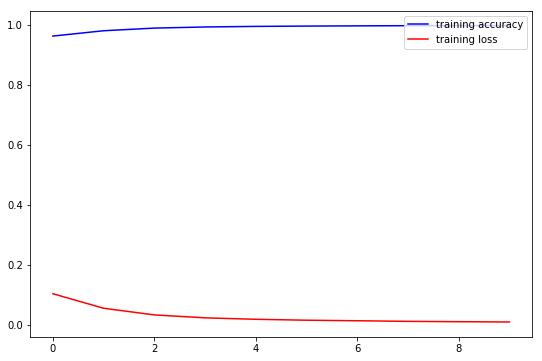

In [36]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(np.array(baseline_model_history.history['acc']), color='blue', label='training accuracy')
ax.plot(np.array(baseline_model_history.history['loss']), color='red', label='training loss')
# ax.set_title('optimizer={}, lr={}'.format('Adam', lr))
ax.legend(loc='upper right')
plt.show()

We see that our model learns as it progresses through the epochs. We have good scores for training accuracy in each epoch, but let's test overall performance

In [37]:
# evaluate the training and testing performance of our model 
score = baseline_model.evaluate(X_train, y_train, verbose=0)
# get the class probabilities predicted by our MLP on the training set
y_pred = baseline_model.predict(X_train)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print('Train confusion matrix:\n', confusion_matrix(y_train, y_pred))
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train confusion matrix:
 [[1532805   68689]
 [1171047  936283]]
Train loss: 5.384253384901117
Train accuracy: 0.6657333968934628


In [38]:
# evaluate the training and testing performance of our model 
score = baseline_model.evaluate(X_test, y_test, verbose=0)
# get the class probabilities predicted by our MLP on the training set
y_pred = baseline_model.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print('Test confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test confusion matrix:
 [[656897  29457]
 [501002 402140]]
Test loss: 5.375560504454298
Test accuracy: 0.6662722020064705


Build, train, predict and check accuracy of final model

In [39]:
# build the final model
input_dim = X_train_scaled.shape[1]

num_classes = 1
nodes = 100

final_model = Sequential()

final_model.add(Dense(nodes, activation='relu', kernel_initializer='uniform', 
                input_dim = input_dim))

final_model.add(Dense(nodes, activation='relu'))
final_model.add(Dense(nodes, activation='relu'))

final_model.add(Dropout(0.2))

final_model.add(Dense(nodes, activation='relu'))
final_model.add(Dense(nodes, activation='relu'))

final_model.add(Dropout(0.2))

final_model.add(Dense(nodes, activation='relu'))
final_model.add(Dense(nodes, activation='relu'))

final_model.add(Dense(num_classes, kernel_initializer='uniform', activation='sigmoid'))

# compile the model
final_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

In [41]:
%%time
if training_flag:
    
# Fit the model
    batch_size = 2**10
    epochs = 10

    final_model_history = final_model.fit(X_train_scaled, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[early_stopping],
                    validation_split=0.1,
                    shuffle=True,)
    
    
    save_weights(folder='data/celeba_vae')
else:
    load_weights(folder='data/celeba_vae')

Train on 3337941 samples, validate on 370883 samples
Epoch 1/10
3337941/3337941 [==============================] - 26s 8us/step - loss: 0.1042 - acc: 0.9616 - val_loss: 0.0788 - val_acc: 0.9700
Epoch 2/10
3337941/3337941 [==============================] - 25s 8us/step - loss: 0.0561 - acc: 0.9786 - val_loss: 0.0404 - val_acc: 0.9842
Epoch 3/10
3337941/3337941 [==============================] - 25s 8us/step - loss: 0.0407 - acc: 0.9847 - val_loss: 0.0301 - val_acc: 0.9892
Epoch 4/10
3337941/3337941 [==============================] - 25s 8us/step - loss: 0.0323 - acc: 0.9882 - val_loss: 0.0265 - val_acc: 0.9906
Epoch 5/10
3337941/3337941 [==============================] - 25s 8us/step - loss: 0.0270 - acc: 0.9903 - val_loss: 0.0208 - val_acc: 0.9931
Epoch 6/10
3337941/3337941 [==============================] - 25s 8us/step - loss: 0.0228 - acc: 0.9920 - val_loss: 0.0167 - val_acc: 0.9944
Epoch 7/10
3337941/3337941 [==============================] - 25s 8us/step - loss: 0.0200 - acc: 0.99

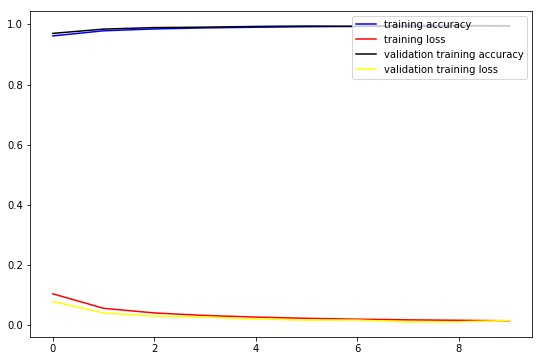

In [42]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(np.array(final_model_history.history['acc']), color='blue', label='training accuracy')
ax.plot(np.array(final_model_history.history['loss']), color='red', label='training loss')
ax.plot(np.array(final_model_history.history['val_acc']), color='black', label='validation training accuracy')
ax.plot(np.array(final_model_history.history['val_loss']), color='yellow', label='validation training loss')
# ax.set_title('optimizer={}, lr={}'.format('Adam', lr))
ax.legend(loc='upper right')
plt.show()

Check accuracy of train set

In [43]:
# evaluate the training and testing performance of our model 
score = final_model.evaluate(X_train, y_train, verbose=0)
# get the class probabilities predicted by our MLP on the training set
y_pred = final_model.predict(X_train)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print('Train confusion matrix:\n', confusion_matrix(y_train, y_pred))
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train confusion matrix:
 [[1541450   60044]
 [1181066  926264]]
Train loss: 5.390812724318497
Train accuracy: 0.6653629290579647


Check accuracy of test set

In [44]:
# evaluate the training and testing performance of our model 
score = final_model.evaluate(X_test, y_test, verbose=0)
# get the class probabilities predicted by our MLP on the training set
y_pred = final_model.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print('Test confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test confusion matrix:
 [[660611  25743]
 [505178 397964]]
Test loss: 5.380858372078886
Test accuracy: 0.6659815438355786


In [50]:
final_y_test = test_df_by_usr.bots

In [49]:

final_x_test = test_df_by_usr.drop(columns = ["created_at", "text", "timestamp", "user_id",
                                           "bots", "year", "month", "day", "hour", "minute"], axis = 1)

In [51]:
final_x_test_scaled = pd.DataFrame(transformer.transform(final_x_test))

In [52]:
# evaluate the training and testing performance of our model 
score = baseline_model.evaluate(final_x_test_scaled, final_y_test, verbose=0)
# get the class probabilities predicted by our MLP on the training set
y_pred = baseline_model.predict(final_x_test_scaled)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print('Test confusion matrix:\n', confusion_matrix(final_y_test, y_pred))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test confusion matrix:
 [[519948  31565]
 [ 37191 605497]]
Test loss: 0.4697286067304131
Test accuracy: 0.9424251026418501


In [53]:
# evaluate the training and testing performance of our model 
score = final_model.evaluate(final_x_test_scaled, final_y_test, verbose=0)
# get the class probabilities predicted by our MLP on the training set
y_pred = final_model.predict(final_x_test_scaled)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print('Test confusion matrix:\n', confusion_matrix(final_y_test, y_pred))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test confusion matrix:
 [[524894  26619]
 [ 35636 607052]]
Test loss: 0.3894988631429476
Test accuracy: 0.9478689098401358


In [62]:
y_pred = final_model.predict(final_x_test_scaled)

In [63]:
test_df_by_usr['y_pred'] = y_pred

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
y_pred = test_df_by_usr.groupby('user_id').y_pred.mean()


In [82]:
botometer_df = pd.DataFrame({'user_id':y_pred.index, 'y_pred':y_pred.values})

Saving the users in test set will be comparing against Botometer result

In [83]:
botometer_df.to_csv('data/botometer_df.csv')

### Comparing Results Against Botometer

In the above results, we measured accuracy of our models by comparing predictions to the classified tweets from the researchers' data. We obtained probabilities, and we assumed that a probability above 0.5 was bot and below was genuine. This metric is vulnerable to the choice of threshold used. Perhaps a better metric would be to compare with an already established machine learning model for detecting if a user is a bot or not.

This is what we did in the following section. We obtained the probability of a user in the test set to be a bot or not based on the result of Botometer. We then compared our predicted score to the Botometer score and test how many of our predictions fall within 10% of the Botometer score for any given user.

In [1]:
import botometer
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import requests

In [2]:
# We are hidding keys for privacy purposes.
mashape_key = 'xxxxxxxxxxxxxxxx'
twitter_app_auth = {
    'consumer_key': 'xxxxxxxxxxxxxxxx',
    'consumer_secret': 'xxxxxxxxxxxxxxxx',
    'access_token': 'xxxxxxxxxxxxxxxx',
    'access_token_secret': 'xxxxxxxxxxxxxxxx',
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          mashape_key=mashape_key,
                          **twitter_app_auth)

Read in accounts from our test set to be used in Botometer.

In [3]:
accounts = pd.read_csv('data/botometer_df.csv', index_col=0)

In [4]:
accounts.shape

(1659, 2)

We request information for the accounts to Botometer. Unfortunatley, not all accounts in our test set are still twitter active accounts. Therefore we try to get information, but if twitter has no info on these accounts, we append a Null to flag it later and ignore it.

In [16]:
bot_pred = []
for i in accounts.user_id:
    try:
        result = bom.check_account(str(i))
        bot_pred.append(result['display_scores']['english'])
    except:
        bot_pred.append(np.nan)

In [17]:
accounts['botometer_score'] = bot_pred

Check that scores were appended and make sense.

In [26]:
accounts.head()

,user_id,y_pred,botometer_score
0,722623,1.505279e-05,0.3
1,785080,1.312385e-05,0.2
2,806585,1.018241e-05,0.2
3,2770511,1.467852e-05,0.1
4,3873101,1.385364e-07,0.5


Botometer returns a probability score between 0 and 5, 0 for human and 5 for bot. We normalize these scores in order to compare with our results.

In [29]:
accounts['bot_score_norm']=(accounts.botometer_score-accounts.botometer_score.min())/(accounts.botometer_score.max()-accounts.botometer_score.min())

In [30]:
accounts.head()

,user_id,y_pred,botometer_score,bot_score_norm
0,722623,1.505279e-05,0.3,0.041667
1,785080,1.312385e-05,0.2,0.020833
2,806585,1.018241e-05,0.2,0.020833
3,2770511,1.467852e-05,0.1,0.000000
4,3873101,1.385364e-07,0.5,0.083333


We check to see if our score is within 10% of the score that Botometer gave, we create an upper and lower bound and see if our score falls between these two values for each user score.

In [33]:
accounts['upper_b'] = accounts.bot_score_norm*1.10
accounts['lower_b'] = accounts.bot_score_norm*0.90

In [34]:
accounts.head()

,user_id,y_pred,botometer_score,bot_score_norm,upper_b,lower_b
0,722623,1.505279e-05,0.3,0.041667,0.045833,0.03750
1,785080,1.312385e-05,0.2,0.020833,0.022917,0.01875
2,806585,1.018241e-05,0.2,0.020833,0.022917,0.01875
3,2770511,1.467852e-05,0.1,0.000000,0.000000,0.00000
4,3873101,1.385364e-07,0.5,0.083333,0.091667,0.07500


In [66]:
clean_df = accounts.loc[accounts.bot_score_norm.isna()==False]

In [67]:
within_10 = [clean_df.y_pred>=clean_df.lower_b]and[clean_df.y_pred<=clean_df.upper_b]

In [68]:
clean_df['within_10'] = within_10[0]

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
clean_df.head()

,user_id,y_pred,botometer_score,bot_score_norm,upper_b,lower_b,within_10
0,722623,1.505279e-05,0.3,0.041667,0.045833,0.03750,True
1,785080,1.312385e-05,0.2,0.020833,0.022917,0.01875,True
2,806585,1.018241e-05,0.2,0.020833,0.022917,0.01875,True
3,2770511,1.467852e-05,0.1,0.000000,0.000000,0.00000,False
4,3873101,1.385364e-07,0.5,0.083333,0.091667,0.07500,True


In [70]:
clean_df.within_10.sum()/len(clean_df)

0.8815399802566634

Our score based on a total of 1013 users that we tested against Botometer was of 88.2% accuracy. This means that for 88.2% of our scores where within 10% of the score given by Botometer.

## 2. Conclusion and Future Work

We set out to create a model that can predict whether a twitter account is likely to be a bot or a genuine account. We were motivated to do this and test our performance against an already working machine learning model created by the Indiana University called Botometer.

We reached out to the researchers who have collected and labeled data related to numerous twitter accounts. We obtained over 6 Million observations corresponding to over 9,000 users. This data was labeled. Cleaning of the data was necesarry as the data was in raw format.

Additionally, we learned that feature engineering is important for this process. We generated various features from the raw data such as time data, if a tweet was a reply, the source of the tweet, and others. Some of these features proved to be useful, some proved to be not useful at all.

We measured the performance of our model against results obtained from Botometer itself. When comparing our model's performance against Botometer's performance, we see that 88.2% of our scores fall within 10% of the scores given by Botometer.

Next iterations of this project could include more feature engineering and tuning the neural network further. Botometer uses over 1000 features to create a score for a given user. We only used 25 features, so there is still a lot of opportunity to improve our model. We present a list of what other features could be done that might useful for prediction. It is important to test these as in our model, we discoverd that some engineered features actually lowered the accuracy score of our models (in particular features related to datetime variables).

A few features that could be engineered for later use in the models:

    - Days a user account has been active.
    - frequencey of tweets for users (per day frequency, per hour frequency, per minute frequency).
    - Categorizing tweet text into topics as a predictor for bot or genuine.